In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from pydantic import BaseModel, Field
# the following includes will allow you display graph diagrams in Jupyter workbook
from IPython.display import display, Image

In [2]:
class MyState(BaseModel):
    messages: list[str]

In [3]:
def node1(state: MyState) -> dict:
    print("Node 1")

    return {"messages": state.messages + ["Hello from Node 1"]}

def node2(state: MyState) -> dict:

    print("Node 2")

    return {"messages": state.messages + ["Hello from Node 2"]}

def node3(state: MyState) -> dict:

    print("Node 3")

    return {"messages": state.messages + ["Hello from Node 3"] }

In [4]:
# create th graph, passing the state class
graph = StateGraph(MyState)

# add nodes to the graph
graph.add_node("node1", node1)
graph.add_node("node2", node2)
graph.add_node("node3", node3)

# add edges to the graph
graph.add_edge(START, "node1")
graph.add_edge("node1", "node2")
graph.add_edge("node2", "node3")
graph.add_edge("node3", END)

# compile the graph
compiled_graph = graph.compile()

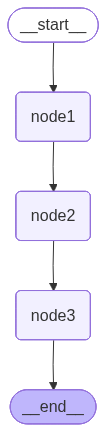

In [5]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [6]:
# run the graph
result = compiled_graph.invoke(MyState(messages=[]))
print("Final State: ", result)

Node 1
Node 2
Node 3
Final State:  {'messages': ['Hello from Node 1', 'Hello from Node 2', 'Hello from Node 3']}


In [7]:
class MyState2(BaseModel):
    messages: list[str]

graph = StateGraph(MyState2)
graph.add_node("node1", node1)
graph.add_node("node2", node2)
graph.add_node("node3", node3)
graph.add_edge(START, "node1")
graph.add_edge("node1", "node2")
graph.add_edge("node1", "node3")
graph.add_edge("node2", END)
compiled_graph = graph.compile()

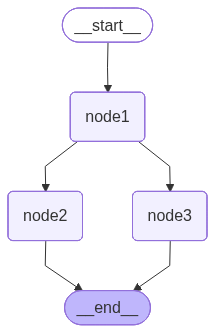

In [8]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [9]:
# run the graph. You will get an error
#result = compiled_graph.invoke(MyState(messages=[]))
#print("Final State: ", result)

In [10]:
from typing import Annotated
from langgraph.graph.message import add_messages

In [11]:
def string_list_reducer(left: list[str], right: list[str])->list[str]:
    return left + right

In [12]:
class MyState3(BaseModel):
    messages: Annotated[list, string_list_reducer]

In [13]:
def node1(state: MyState3) -> dict:

    print("Node 1")

    return {"messages": ["Hello from Node 1"] }

def node2(state: MyState3) -> dict:

    print("Node 2")

    return {"messages": ["Hello from Node 2"]}

def node3(state: MyState3) -> dict:

    print("Node 3")

    return {"messages": ["Hello from Node 3"]}

In [14]:
graph = StateGraph(MyState3)
graph.add_node("node1", node1)
graph.add_node("node2", node2)
graph.add_node("node3", node3)
graph.add_edge(START, "node1")
graph.add_edge("node1", "node2")
graph.add_edge("node1", "node3")
graph.add_edge("node2", END)
compiled_graph = graph.compile()

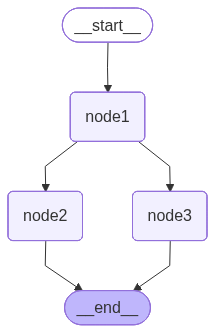

In [15]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [16]:
# run the graph.
result = compiled_graph.invoke(MyState3(messages=[]))
print("Final State: ", result)

Node 1
Node 2
Node 3
Final State:  {'messages': ['Hello from Node 1', 'Hello from Node 2', 'Hello from Node 3']}


In [17]:
def random_node(state: MyState3) -> dict:

    # create a random boolean value

    import random

    random_value = str(random.choice([True, False]))

    print(f"random node: random_value = {random_value}")

    return {"messages": [random_value]}

In [18]:
def conditional_edge(state: MyState3) -> str:

    # Check the content of the last message in the state

    if state.messages[-1] == "True":
        return "node2"
    else:
        return "node3"

In [19]:
graph = StateGraph(MyState3)
graph.add_node("random_node", random_node)
graph.add_node("node2", node2)
graph.add_node("node3", node3)
# edges
graph.add_edge(START, "random_node")
graph.add_conditional_edges("random_node", conditional_edge)
graph.add_edge("node2", END)
graph.add_edge("node3", END)
# compile the graph
compiled_graph = graph.compile()

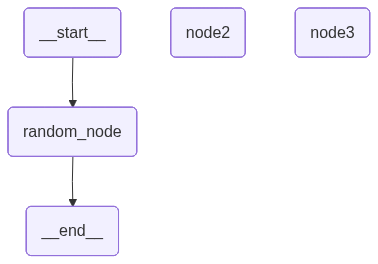

In [20]:
Image(compiled_graph.get_graph().draw_mermaid_png())

In [21]:
result = compiled_graph.invoke(MyState3(messages=[]))

random node: random_value = True
Node 2


In [22]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import (HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage )
import os
from dotenv import load_dotenv

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [23]:
load_dotenv()

True

In [24]:
model = ChatGoogleGenerativeAI(model=os.getenv("GOOGLE_API_MODEL"),temperature=0)

E0000 00:00:1761127511.473831    7055 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [25]:
class MyMessagesState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [26]:
def llm_node(state: MyMessagesState) -> dict:
    
    response = model.invoke(state.messages)

    return {"messages": response}

In [27]:
graph = StateGraph(MyMessagesState)
graph.add_node("llm_node", llm_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
compiled_graph = graph.compile()

In [28]:
user_message = HumanMessage(content="What is the capital of France?")
result = compiled_graph.invoke(MyMessagesState(messages=[user_message]))
print(result)

{'messages': [HumanMessage(content='What is the capital of France?', additional_kwargs={}, response_metadata={}, id='81d4a999-2e3f-4436-924c-685eee8066b6'), AIMessage(content='The capital of France is **Paris**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--bc980f4c-db48-4fde-b0b2-002cbbc0d683-0', usage_metadata={'input_tokens': 8, 'output_tokens': 8, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})]}


In [29]:
result['messages'][-1].content

'The capital of France is **Paris**.'

In [30]:
class Result(BaseModel):

    capital: str = Field(..., description="The capital city of the given country.")

    population: int = Field(..., description="The population of the given country.")

In [31]:
# create structured_ouptut runnable for the model
structured_llm = model.with_structured_output(Result)

In [32]:
class StructuredState(BaseModel):

    result: Result = None

    input: str

In [33]:
def structure_node(state: StructuredState) -> dict:

    msgs = [HumanMessage(content=state.input)]

    response = structured_llm.invoke(msgs)

    return {"result": response}

In [34]:
result = structured_llm.invoke('What is the capital of France?')
print(result)

capital='Paris' population=65300000


In [35]:
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

In [36]:
@tool
def read_file_tool(file_path: str) -> str:

    """ Read the contents of a file given its file path. """

    with open(file_path, 'r') as file:

        return file.read()

In [93]:
@tool
def write_file_tool(text: str, file_name: str) -> str:
    
    """ Save text to a file with a given file name and return the file name. """
    import uuid
    str(uuid.uuid4()) + '.txt'
    file_name = file_name + '_' + str(uuid.uuid4()) + '.txt'
    try:
        with open(file_name, 'w', encoding='utf-8') as f:
            f.write(text)
        return file_name
    except Exception as e:
        print(f"Error saving file: {e}")


In [94]:
tools = [read_file_tool, write_file_tool]
tool_model = model.bind_tools(tools)

In [95]:
# llm node
def llm_node_with_tools(state: MyMessagesState) -> dict:

    response = tool_model.invoke(state.messages)

    return {"messages": response}

In [96]:
graph = StateGraph(MyMessagesState)
graph.add_node("llm_node", llm_node_with_tools)
graph.add_node("tool_node", ToolNode(tools))
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", "tool_node")
graph.add_edge("tool_node", END)
tool_graph = graph.compile()

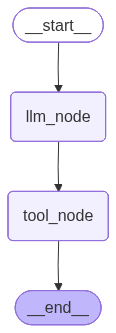

In [97]:
Image(tool_graph.get_graph().draw_mermaid_png())

In [115]:
messages = [ HumanMessage(content="Write the text 'Hello world' to a file with file name 'hello' ")]

result = tool_graph.invoke(MyMessagesState(messages=messages))
print(result['messages'][-1].content)

hello_28b81f67-9147-4300-818a-08fcd721eaaf.txt


In [99]:
def conditional_edge(state: MyMessagesState) -> bool:

    last_message = state.messages[-1]

    return last_message.tool_calls != []

In [118]:
react_graph = StateGraph(MyMessagesState)
react_graph.add_node("llm_node", llm_node_with_tools)
react_graph.add_node("tool_node", ToolNode(tools))
react_graph.add_edge(START, "llm_node")
react_graph.add_conditional_edges("llm_node", conditional_edge,path_map={True: "tool_node", False: END})
react_graph.add_edge("tool_node", "llm_node")

compiled_react_graph = react_graph.compile()

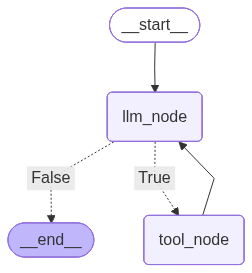

In [119]:
Image(compiled_react_graph.get_graph().draw_mermaid_png())

In [120]:
messages = [ HumanMessage(content="Write the text 'Hello world' to a file with file name 'hello' ")]
#messages = [ HumanMessage(content="Read the contents of the file 'test.txt'. Then summarise the contents. Then save the summary to a file with a random name.")]

result = compiled_react_graph.invoke(MyMessagesState(messages=messages))
print(result['messages'][-1].content)

In [116]:
write_file_tool.invoke({"text": "Hello world", "file_name": "hello"})

'hello_1c1cc3cf-e06f-4ba3-9a34-ea6951d72eb9.txt'

In [103]:
print(write_file_tool.name)

write_file_tool


In [104]:
print(write_file_tool.description)

Save text to a file with a given file name and return the file name.


In [109]:
print(write_file_tool)

name='write_file_tool' description='Save text to a file with a given file name and return the file name.' args_schema=<class 'langchain_core.utils.pydantic.write_file_tool'> func=<function write_file_tool at 0x763210eb5c60>


In [112]:
type(write_file_tool.args_schema)

pydantic._internal._model_construction.ModelMetaclass

In [106]:
print(write_file_tool.response_format)

content
